## Simulating the eBOSS Instrument

This notebook goes through how to simulate eBOSS spectra for a given. The model used here is defined so that it has an AB magnitude of 20 in each SDSS filter, and extends beyond the wavelength range defined in `eboss.yaml` for interpolation.

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/belaabolfathi/anaconda3/envs/galsim/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['vstack']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
import specsim.simulator

from astropy.io import fits
from astropy.table import Table, vstack

#### Simulate a source model

In [39]:
import speclite
import scipy
import astropy.units as u

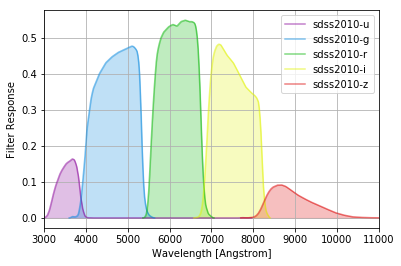

In [199]:
sdss = speclite.filters.load_filters('sdss2010-*')
speclite.filters.plot_filters(sdss, wavelength_limits=(3000, 11000))

In [204]:
def quad(x):
    return(x ** 2 / 1e-16)

wlen = np.arange(np.min(sdss[0].wavelength)-1, np.max(sdss[-1].wavelength)+1) * u.Angstrom
flux = quad(np.linspace(8e-17, 1e-17, len(wlen))) * u.erg / (u.cm**2 * u.s * u.Angstrom)

sdss.get_ab_magnitudes(flux, wlen)

sdss2010-u,sdss2010-g,sdss2010-r,sdss2010-i,sdss2010-z
float64,float64,float64,float64,float64
20.477972811385413,20.18454110689822,20.04927144380726,20.15160992619304,20.52966327832596


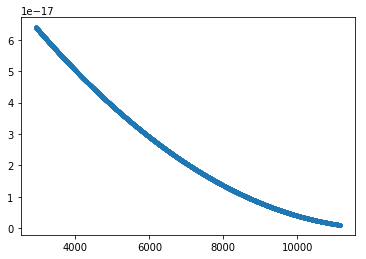

In [205]:
plt.plot(wlen, flux, '.')
plt.show()

In [212]:
sourceAB = Table([wlen, flux], names=('WAVELENGTH', 'FLUX'))
sourceAB.write('/Users/belaabolfathi/Documents/repos/specsim/specsim/data/sdss/spectra/spec-ABmag20.0.dat', format='ascii', overwrite=True)

#### Prepare source model to be read from config file

In [34]:
sourceAB = Table.read('/Users/belaabolfathi/Data/desimodel/data/spectra/spec-ABmag22.0.dat', format='ascii')

We need to pad the source model so that it extends beyond the the wavelength grid in the config file:

In [26]:
beg = np.arange(2000, np.min(sourceAB['WAVELENGTH']), 0.1)
end = np.arange(np.max(sourceAB['WAVELENGTH']), 11000, 0.1)
col_beg = np.full(len(beg), sourceAB['FLUX'][0])
col_end = np.full(len(end), sourceAB['FLUX'][-1])
pad_beg = Table([beg, col_beg], names=('WAVELENGTH', 'FLUX'))
pad_end = Table([end, col_end], names=('WAVELENGTH', 'FLUX'))
adjusted_source = vstack([pad_beg, sourceAB])
adjusted_source = vstack([new_data, pad_end])

In [31]:
adjusted_source.write('/Users/belaabolfathi/Documents/repos/specsim/specsim/data/sdss/spectra/spec-ABmag22.0.dat', 
               format='ascii', overwrite=True)

#adjusted_source = Table.read('/Users/belaabolfathi/Documents/repos/specsim/specsim/data/sdss/spectra/spec-ABmag22.0.dat', 
            #format='ascii)

#### Compare specsim output in DESI and eBOSS modes

##### Initialize each simulator

In [213]:
desi = specsim.simulator.Simulator('desi', num_fibers=1, camera_output=True)
eboss = specsim.simulator.Simulator('eboss', num_fibers=1, camera_output=True)

##### Get simulated output for each camera

In [215]:
def get_camera_output(simulator, seed=123):
    gen = np.random.RandomState(seed)
    simulator.simulate()
    simulator.generate_random_noise(gen)
    sim = simulator.simulated
    cam1 = simulator.camera_output[0]
    cam2 = simulator.camera_output[1]
    
    if simulator == desi:
        cam3 = simulator.camera_output[2]
        return(cam1, cam2, cam3)
    
    else:
        return(cam1, cam2)
    
desi_cam1, desi_cam2, desi_cam3 = get_camera_output(desi)
eboss_cam1, eboss_cam2 = get_camera_output(eboss)

/Users/belaabolfathi/Documents/repos/specsim/specsim/simulator.py:600: RuntimeWarning: invalid value encountered in less
  random_state.poisson(mean_electrons) - mean_electrons +
/Users/belaabolfathi/Documents/repos/specsim/specsim/simulator.py:600: RuntimeWarning: invalid value encountered in greater
  random_state.poisson(mean_electrons) - mean_electrons +


##### Plot DESI and eBOSS (simulated) inverse variance

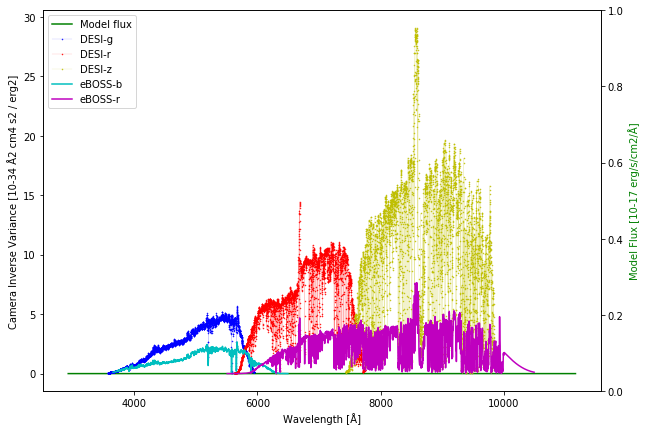

In [225]:
fig, ax1 = plt.subplots(figsize=(10,7))

ax2 = ax1.twinx()
ax1.plot(wlen, flux, 'g', label='Model flux') # 1e-17 erg/s/cm2/A
ax1.plot(desi_cam1['wavelength'], desi_cam1['flux_inverse_variance'] * 1e-34, 'b.-', ms=1, lw=0.1, label='DESI-g') # 1e34 A2 cm4 s2 / erg2
ax1.plot(desi_cam2['wavelength'], desi_cam2['flux_inverse_variance'] * 1e-34, 'r.-',  ms=1, lw=0.1, label='DESI-r') # 1e34 A2 cm4 s2 / erg2
ax1.plot(desi_cam3['wavelength'], desi_cam3['flux_inverse_variance'] * 1e-34, 'y.-',  ms=1, lw=0.1, label='DESI-z') # 1e34 A2 cm4 s2 / erg2
ax1.plot(eboss_cam1['wavelength'], eboss_cam1['flux_inverse_variance'] * 1e-34, 'c', label='eBOSS-b') # 1e34 A2 cm4 s2 / erg2
ax1.plot(eboss_cam2['wavelength'], eboss_cam2['flux_inverse_variance'] * 1e-34, 'm', label='eBOSS-r') # 1e34 A2 cm4 s2 / erg2

ax1.legend(loc=2)
ax1.set_xlabel('Wavelength [Å]')
ax1.set_ylabel('Camera Inverse Variance [10-34 Å2 cm4 s2 / erg2]', color='k')
ax2.set_ylabel('Model Flux [10-17 erg/s/cm2/Å]', color='g')
plt.show()